In [128]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pycountry
import pycountry_convert as pc
import geopandas as gpd
from descartes.patch import PolygonPatch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib as mpl

## Reading Data

In [170]:
# data_loc = os.path.join(os.getcwd(), 'Dataset', 'data.csv')
# df = pd.read_csv(data_loc)
df = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/spotify/data.csv.zip')

# Explore how artists and tracks’ popularity varies in time across the global stage

##  1.Do regions share the same top-ranking artists or songs?
##  2.Does the popularity of a track in one region predict its (upcoming?) popularity in other regions ?
##  3.Are there any patterns in what day(s) of the week and/or months experience the most streams? 
##  4.Does reaching the top N (e.g., 5, 10, 20) positions have any relationship with the subsequent lifetime of a track in the data?
##  5.Are there any patterns in what day(s) of the week and/or months experience the most streams?Do these patterns, if any, differ by region?
##  6.Take a ‘deep-dive’ into the work of one (or a collection of) artist(s) and examine trends across their apparent most popular tracks.

# Exploratory Data Analysis (EDA)

## Data Cleaning & Wrangling

### Data Cleaning

In [171]:
# Drop NaN values
df.dropna(subset=['Track Name', 'Artist'], how='all', inplace=True)

# Drop unused column 'URL'
df.drop(columns='URL', inplace=True)

df

,Position,Track Name,Artist,Streams,Date,Region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,2017-01-01,ec
1,2,Chantaje,Shakira,19270,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,2017-01-01,ec
4,5,Safari,J Balvin,14269,2017-01-01,ec
...,...,...,...,...,...,...
3441192,196,More Than You Know,Axwell /\ Ingrosso,2126,2018-01-09,hk
3441193,197,Issues,Julia Michaels,2117,2018-01-09,hk
3441194,198,Tuo Fei Lun,Eason Chan,2112,2018-01-09,hk
3441195,199,面具,Alfred Hui,2102,2018-01-09,hk


### Data Wrangling

In [172]:
# Change date column to date type
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Turn 'Date' column into three columns 'Year', 'Month', 'Weekday'  
df['Year'] = pd.DatetimeIndex(df.Date).year
df['Month'] = pd.DatetimeIndex(df.Date).month
df['Weekday'] = df['Date'].dt.day_name()

In [173]:
# Convert region codes to corresponding full names
df['Region Code'] = df['Region'].str.upper()

def getRegionName(region):
    if region == 'GLOBAL':
        return region.title()
    return pc.country_alpha2_to_country_name(region,cn_name_format="default")

def getContinentName(region):
    if region == 'GLOBAL':
        return region.title()
    return pc.country_alpha2_to_continent_code(region)

df['Continent'] = df['Region Code'].apply(getContinentName)
df['Region'] = df['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
df['Continent'] = df['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
df['Region'] = df['Region'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

In [174]:
df

,Position,Track Name,Artist,Streams,Date,Region,Year,Month,Weekday,Region Code,Continent
0,1,Reggaetón Lento (Bailemos),CNCO,19272,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
1,2,Chantaje,Shakira,19270,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
3,4,Vente Pa' Ca,Ricky Martin,14954,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
4,5,Safari,J Balvin,14269,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
...,...,...,...,...,...,...,...,...,...,...,...
3441192,196,More Than You Know,Axwell /\ Ingrosso,2126,2018-01-09,Hong Kong,2018,1,Tuesday,HK,Asia
3441193,197,Issues,Julia Michaels,2117,2018-01-09,Hong Kong,2018,1,Tuesday,HK,Asia
3441194,198,Tuo Fei Lun,Eason Chan,2112,2018-01-09,Hong Kong,2018,1,Tuesday,HK,Asia
3441195,199,面具,Alfred Hui,2102,2018-01-09,Hong Kong,2018,1,Tuesday,HK,Asia


## Data Visualisation for EDA

In [30]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_streams = df.groupby('Region')['Streams'].sum()
df_world_streams = df_world.merge(df_streams, how="left", left_on=['name'], right_on=['Region'])

Text(0.5, 1.0, 'Streams around the world')

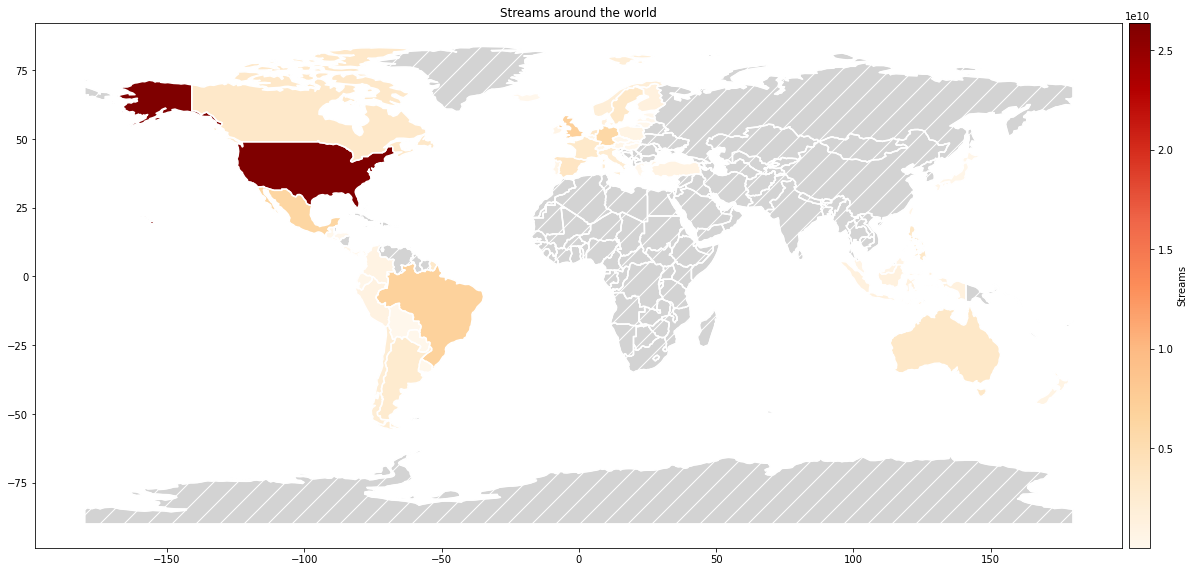

In [71]:
# As a first step, let’s plot the basic map – world with boundary only. 
# In the next steps, we will colour the countries that we are interested in.
ax = df_world["geometry"].boundary.plot(figsize=(20,16), color='white')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad="0.5%")
cax.set_ylabel('Streams')
df_world_streams.plot(column='Streams', ax=ax, cax=cax, cmap='OrRd', 
#                      scheme='quantiles',
                     legend=True, 
#                      legend_kwds={"labels": ['Streams','Streams','Streams','Streams','Streams']},
                     legend_kwds={"label": 'Streams'},
                     missing_kwds={'color': 'lightgrey',
                     "edgecolor": "white", "hatch": "/"})

ax.set_title("Streams around the world")

# Shading the countries that didn’t participate

Text(0.5, 1.0, 'Streams around the world')

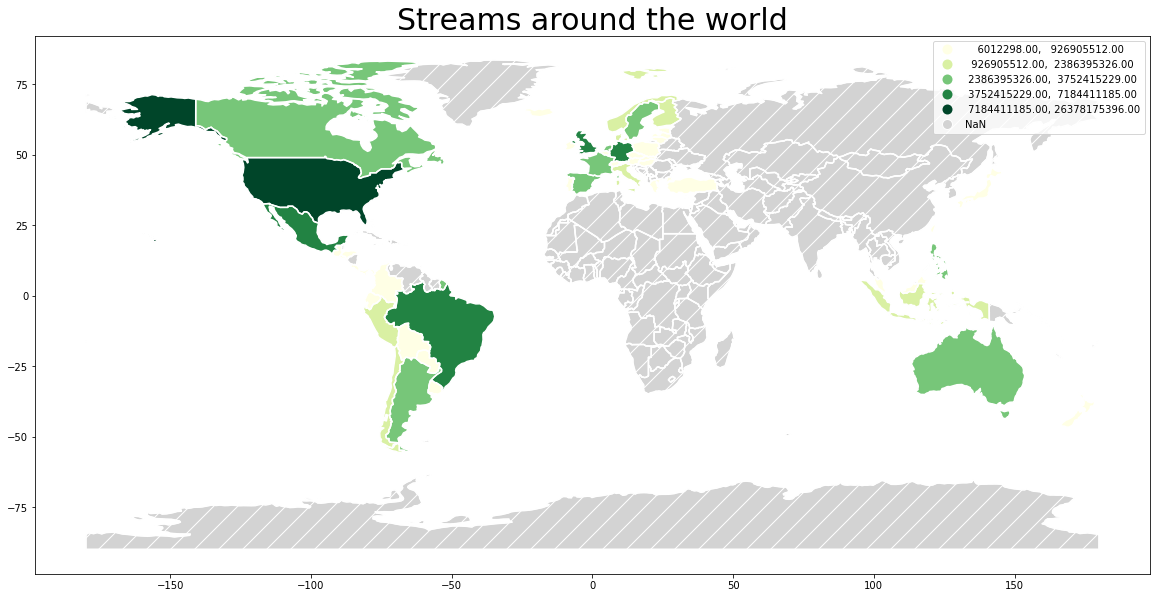

In [161]:
# As a first step, let’s plot the basic map – world with boundary only. 
# In the next steps, we will colour the countries that we are interested in.
ax = df_world["geometry"].boundary.plot(figsize=(20,16), color='white')
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="2%", pad="0.5%")
# cax.set_ylabel('Streams')
df_world_streams.plot(column='Streams', ax=ax, 
#                      cax=cax, 
                     cmap='YlGn', 
                     scheme='fisher_jenks',
#                      k=10,
                     legend=True, 
#                      legend_kwds={
#                          "labels": [r'$<1.25x10^8$',
#                                     r'$\geq1.25x10^8$',
#                                     r'$\geq4.09x10^8$',
#                                     r'$\geq9.88x10^8$', 
#                                     r'$\geq3.22x10^9$']},
#                      legend_kwds={"label": 'Streams'},
                     missing_kwds={'color': 'lightgrey',
                     "edgecolor": "white", "hatch": "/"})

ax.set_title("Streams around the world", fontsize=30)

# Shading the countries that didn’t participate

##  1.Do regions share the same top-ranking artists or songs?

In [175]:
def plotTopXThings(region, Things, base_on, X = 10):
    """
    Things: 'Artist'/'Track Name'
    base_on: 'Position'/ 'Streams'
    """
    if base_on == 'Position':
        top = df[df['Region'] == region].loc[(df['Position'] == 1), Things].value_counts()
        top = top.to_frame().reset_index()
        top.columns = [Things, 'Counts']
        topX = top.nlargest(X,'Counts')
        
        x_axis = 'Counts'
        
    elif base_on == 'Streams':
        top = df[df['Region'] == region].groupby(Things)['Streams'].sum()
        top = top.to_frame().reset_index()
        topX = top.nlargest(X,'Streams')
        
        x_axis = 'Streams'
        

    # Declaring the figure or the plot (y, x) or (width, height)
    plt.figure(figsize = (16,10))

    plots = sns.barplot(x= x_axis, y=Things, data=topX)
    
    if base_on == 'Position':
        # Annotating the bar plot with the values (Position 1 counts)
        # Iterrating over the bars one-by-one
        for bar in plots.patches:
            # Using Matplotlib's annotate function and
            plots.annotate(format(bar.get_width(), '.0f'),
                           # passing the coordinates where the annotation shall be done
                           # x-coordinate: 3.5+bar.get_width()
                           # y-coordinate: bar.get_y() + bar.get_height()/2
                           (3.5+bar.get_width(), bar.get_y() + bar.get_height()/2),
                           # ha and va stand for the horizontal and vertical alignment
                           ha='center', va='center')

        # Setting the label for x-axis
        plt.ylabel(Things, size=18)

        # Setting the label for y-axis
        plt.xlabel("Frequency of Reaching Position 1", size=18)

        # Setting the title for the graph
        plt.title(f"Top-ranking {Things} (Region: {region})", size=22)

        # Finally showing the plot
        return plt.show()

        
    elif base_on == 'Streams':
        # Setting the label for x-axis
        plt.ylabel(Things, size=18)

        # Setting the label for y-axis
        plt.xlabel("Number of Streams", size=18)

        # Setting the title for the graph
        plt.title(f"Top-ranking {Things} (Region: {region})", size=22)

        # Finally showing the plot
        return plt.show()



### Artist

In [176]:
plotTopXThings('global', 'Artist', 'Streams')
plotTopXThings('us', 'Artist', 'Streams')
plotTopXThings('gb', 'Artist', 'Streams')
plotTopXThings('jp', 'Artist', 'Streams')

ValueError: min() arg is an empty sequence

<Figure size 1152x720 with 0 Axes>

### Track Name

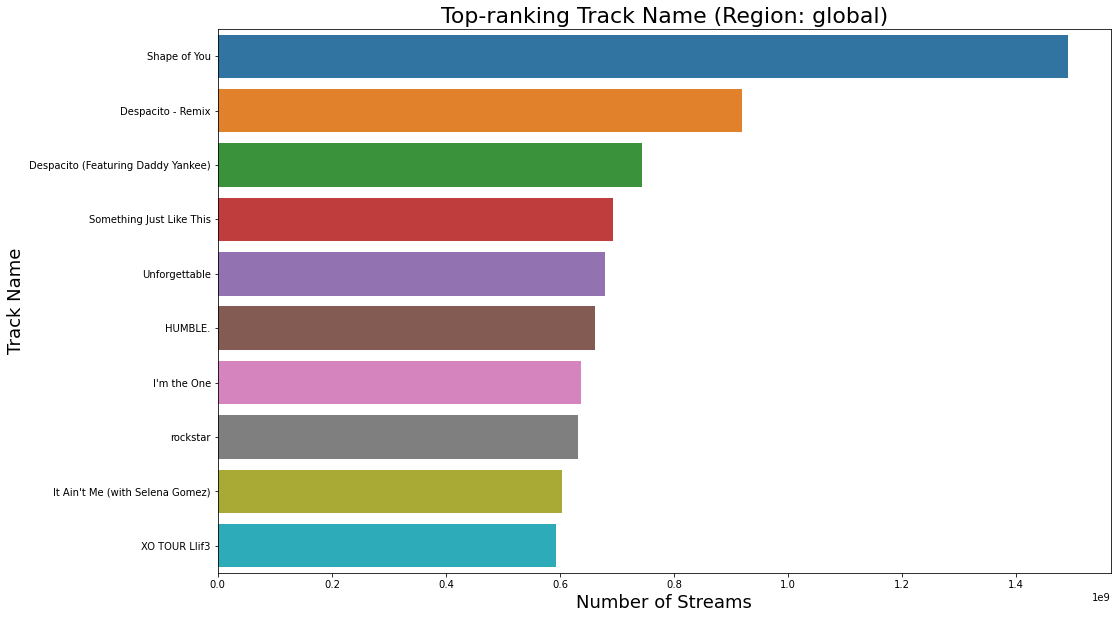

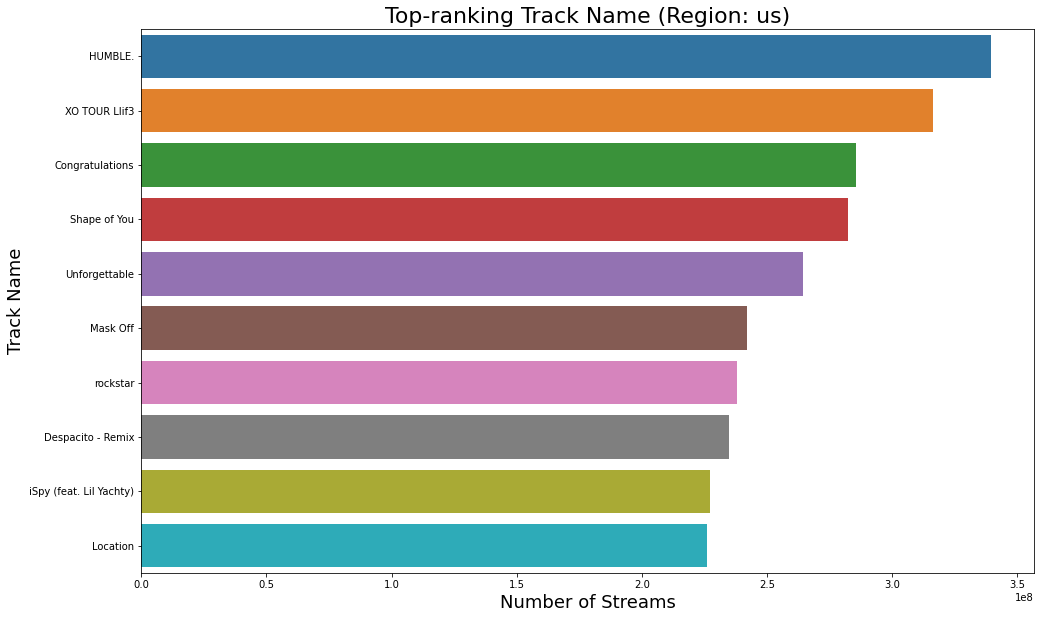

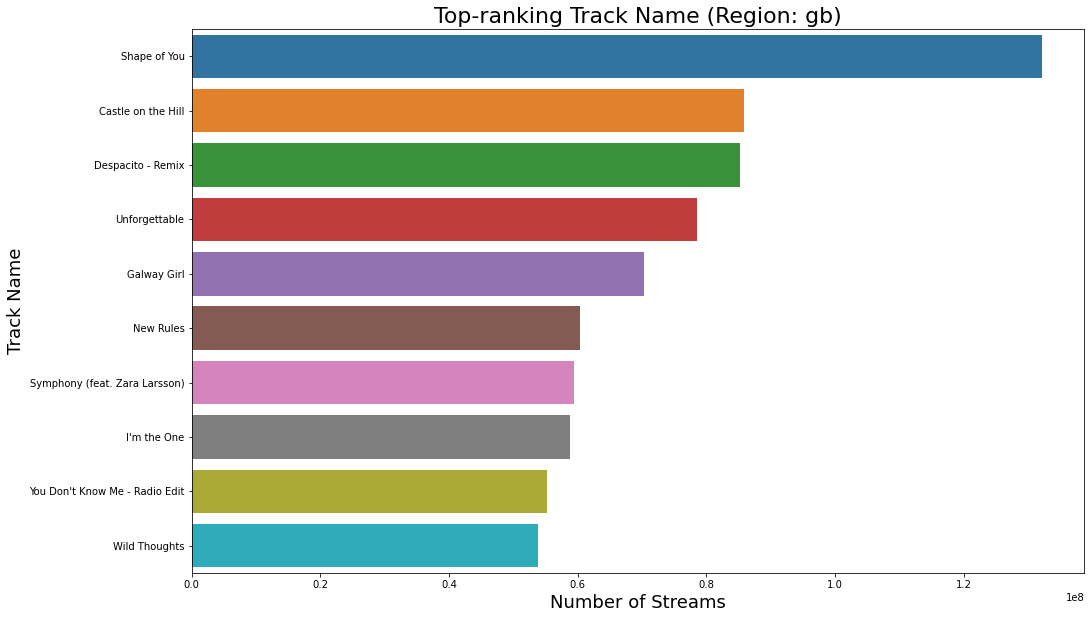

D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25171 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28779 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 25171 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda\lib\site-packages\ma

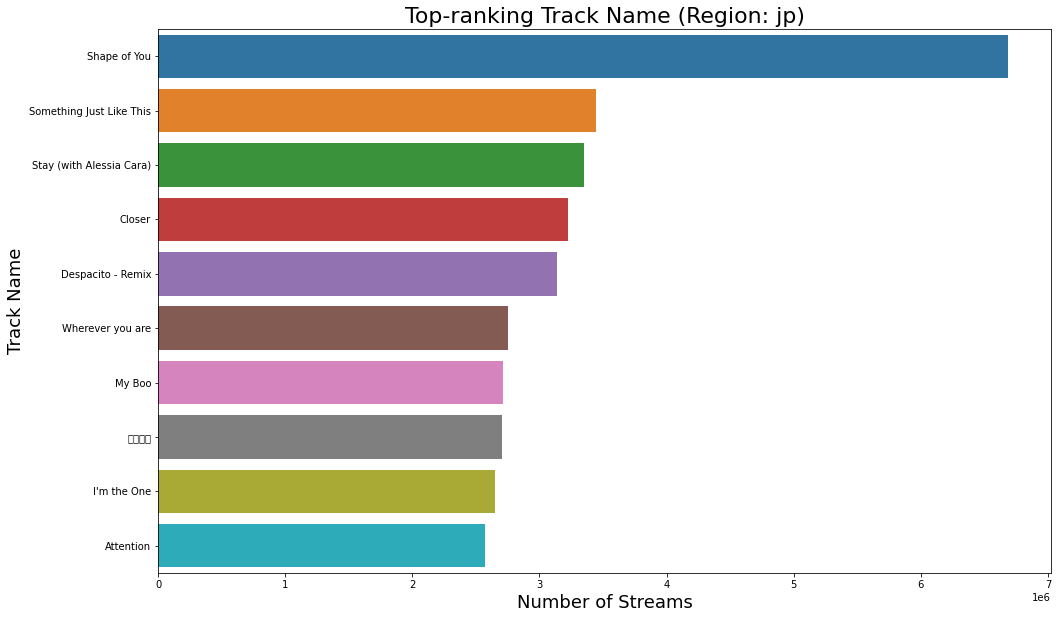

D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 39770 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 38651 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35222 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-package

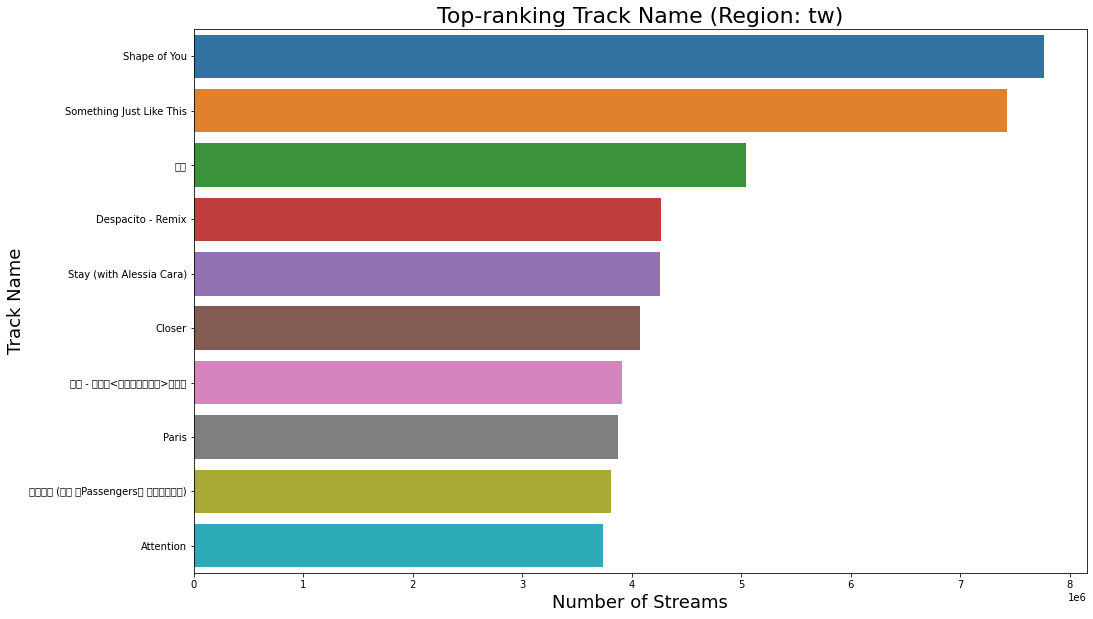

In [7]:
plotTopXThings('global', 'Track Name', 'Streams')
plotTopXThings('us', 'Track Name', 'Streams')
plotTopXThings('gb', 'Track Name', 'Streams')
plotTopXThings('jp', 'Track Name', 'Streams')
plotTopXThings('tw', 'Track Name', 'Streams')

##  2.Does the popularity of a track in one region predict its (upcoming?) popularity in other regions ?



## 4.Does reaching the top N (e.g., 5, 10, 20) positions have any relationship with the subsequent lifetime of a track in the data?

Hypothesis: The higher position means longer lifetime of a track 

In [22]:
def plotTopXTrend(region,X):
    top = df[df['Region'] == region].groupby(['Track Name','Artist'])['Streams'].sum()
    top = top.to_frame().reset_index()
    topX = top.nlargest(X,'Streams')
    topX_tracks = topX['Track Name'].values.tolist()
    topX_artists = topX['Artist'].values.tolist()
    topX_tuples = list(zip(topX_tracks,topX_artists))
    
    plt.figure(figsize = (16,10))

    for track, artist in topX_tuples:
        d = df[(df['Region'] == region) & (df['Track Name'] == track) & (df['Artist'] == artist)]
        plt.plot(d['Date'], d['Position'], label=track)
        plt.ylim([0, 50])
        plt.yticks(np.arange(1, 201, 10))
        plt.gca().invert_yaxis()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
        plt.gcf().autofmt_xdate()
        plt.legend()

    plt.ylabel('Position', size=18)
    plt.title(f"Trend of Top {X} Tracks (Region: {region})", size=22)
    plt.show()
    


### Trends

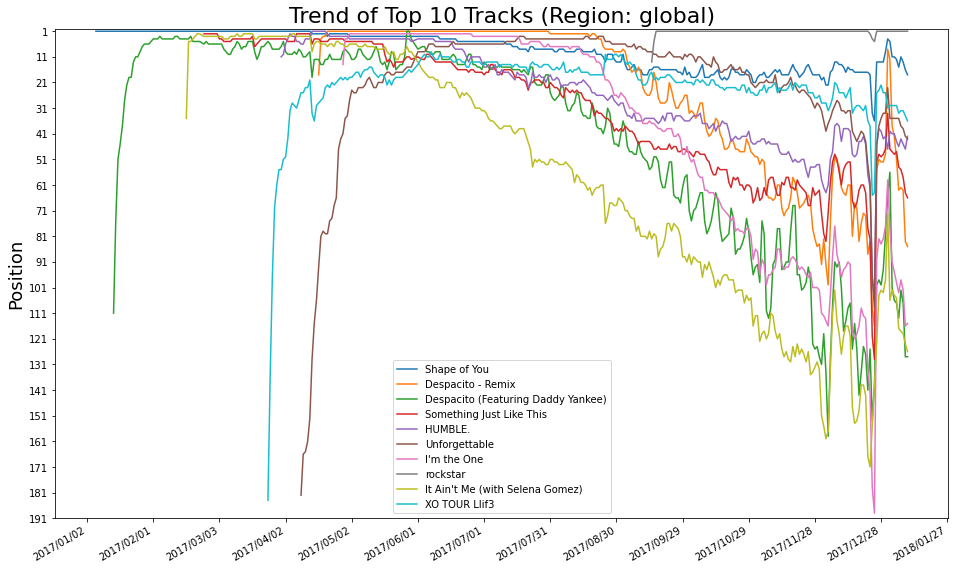

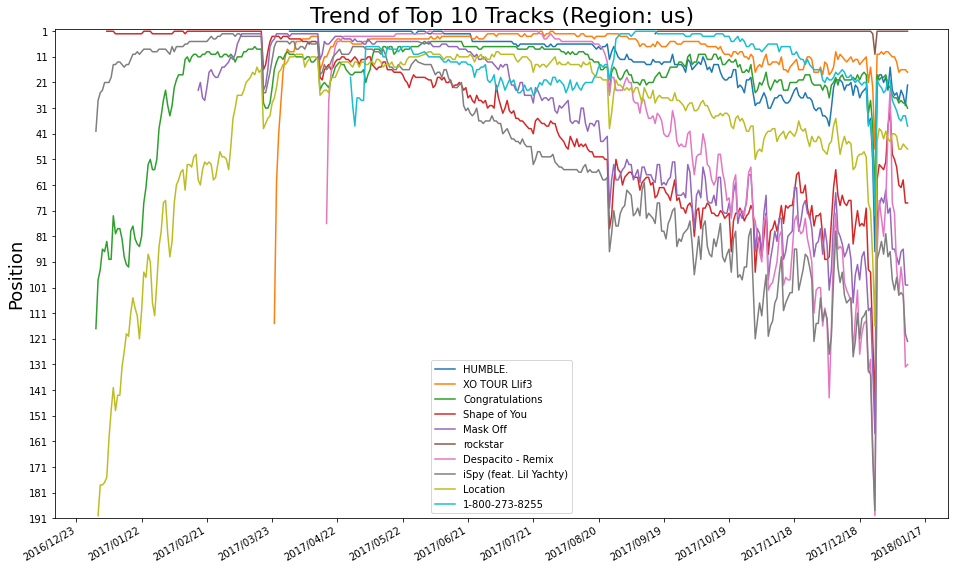

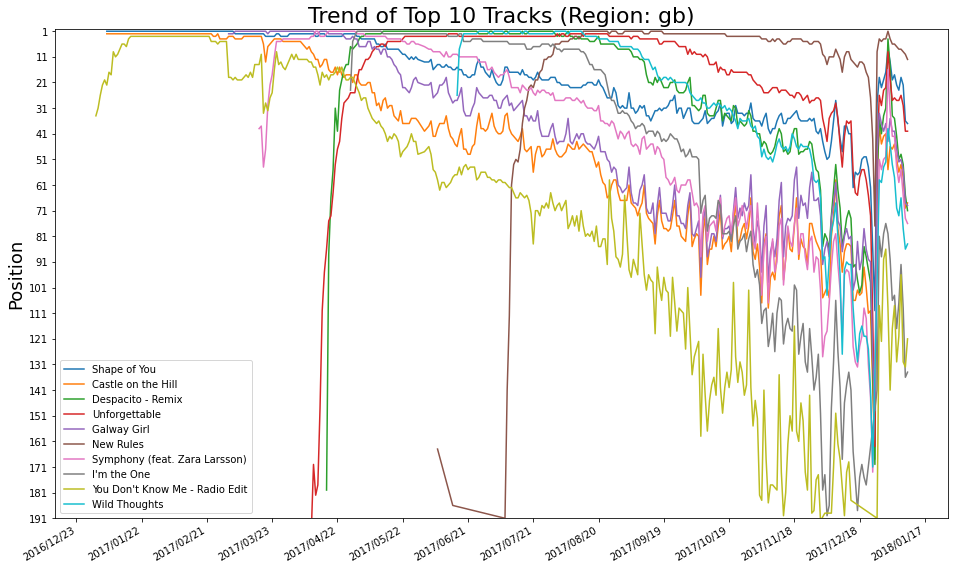

D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25171 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28779 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 25171 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda\lib\site-packages\ma

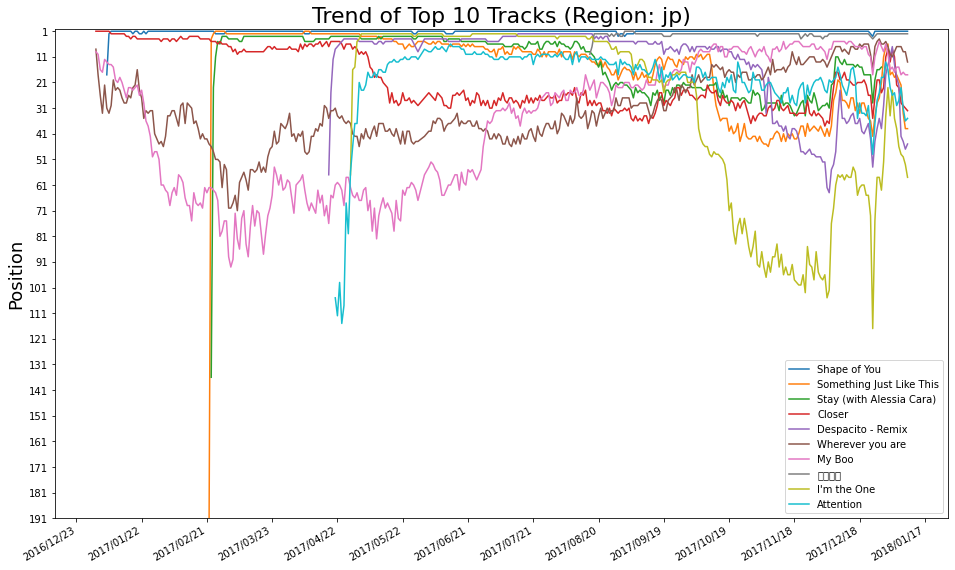

In [23]:
plotTopXTrend('global', 10)
plotTopXTrend('us', 10)
plotTopXTrend('gb', 10)
plotTopXTrend('jp', 10)

## Linear Regression Modeling: Rank Prediction

Multi-output regression is used to predict multiple output/target variables. Artist and streams are used to forecast average/max/min rank variables simultaneously. As tuning /fitting process, after standardizing(scaling) data, PCA is applied to find linear combinations of current predictor variables and created new "principal components". This process helped to reduce dimensionality and understand the most important "directions" in the data. However, after plotting the Linear Regression of actual vs prediction residual I realized that the outcome did not change in proportion to a change in any of the inputs, in other words, the plot indicated nonlinearity

In [195]:
df[df['Region Code']=='GLOBAL']

,Position,Track Name,Artist,Streams,Date,Region,Year,Month,Weekday,Region Code,Continent
3116643,1,Starboy,The Weeknd,3135625,2017-01-01,Global,2017,1,Sunday,GLOBAL,Global
3116644,2,Closer,The Chainsmokers,3015525,2017-01-01,Global,2017,1,Sunday,GLOBAL,Global
3116645,3,Let Me Love You,DJ Snake,2545384,2017-01-01,Global,2017,1,Sunday,GLOBAL,Global
3116646,4,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,2356604,2017-01-01,Global,2017,1,Sunday,GLOBAL,Global
3116647,5,One Dance,Drake,2259887,2017-01-01,Global,2017,1,Sunday,GLOBAL,Global
...,...,...,...,...,...,...,...,...,...,...,...
3190438,196,Delicate,Taylor Swift,507893,2018-01-09,Global,2018,1,Tuesday,GLOBAL,Global
3190439,197,Look At Me!,XXXTENTACION,505171,2018-01-09,Global,2018,1,Tuesday,GLOBAL,Global
3190440,198,The Scientist,Coldplay,504066,2018-01-09,Global,2018,1,Tuesday,GLOBAL,Global
3190441,199,'Till I Collapse,Eminem,501337,2018-01-09,Global,2018,1,Tuesday,GLOBAL,Global


In [196]:
df_Global = df[df['Region Code']=='GLOBAL']

# Dummification of categorical variable 
df_Global_dummies = pd.get_dummies(data=df_Global , columns=['Artist'])
df_Global_dummies.set_index(pd.to_datetime(df_Global_dummies['Date']), inplace = True)

#Choosing matrix 
X = df_Global_dummies.drop(
    columns = ['Date','Year', 'Month', 'Weekday','Region Code', 'Continent', 'Position', 'Track Name', 'Region'])

# defining target
y = df_Global_dummies['Position']

In [205]:
# split data into train/test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.shape

(55338, 459)

In [124]:
model = sm.GLM(y_train, X_train, family = sm.families.Poisson(link = sm.families.links.log)).fit()
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
model.summary()

<ipython-input-124-8f5c6b2a402a>:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  model = sm.GLM(y_train, X_train, family = sm.families.Poisson(link = sm.families.links.log)).fit()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Position   No. Observations:                55338
Model:                            GLM   Df Residuals:                    54896
Model Family:                 Poisson   Df Model:                          441
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3110e+05
Date:                Sat, 02 Apr 2022   Deviance:                   1.2133e+05
Time:                        15:44:06   Pearson chi2:                 1.91e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Streams                                          -1.448e-06   1.52e-09   -952.863      0.000   -1.45e-06   -1.44e-06
Artist_*NSYNC                                        6.1244      0.054    114.048      0.000       6.019       6.230
Artist_187 Strassenbande                             5.7885      0.037    156.784      0.000       5.716       5.861
Artist_2 Chainz                                      5.7368      0.007    861.783      0.000       5.724       5.750
Artist_21 Savage                                     5.7413      0.006   1021.943      0.000       5.730       5.752
Artist_22 Savage                                     5.8985      0.024    249.922      0.000       5.852       5.945
Artist_6LACK                                         5.8601      0.036    161.206      0.000       5.789       5.931
Artist_6ix9ine                                       5.9660      0.014    426.123      0.000       5.939       5.993
Artist_A Boogie Wit da Hoodie                        5.7640      0.006    887.034      0.000       5.751       5.777
Artist_A R I Z O N A                                 5.7143      0.011    501.152      0.000       5.692       5.737
Artist_A$AP Ferg                                     5.7683      0.012    497.784      0.000       5.746       5.791
Artist_A$AP Mob                                      6.0609      0.071     85.709      0.000       5.922       6.200
Artist_AC/DC                                         5.9715      0.045    132.832      0.000       5.883       6.060
Artist_AJR                                           5.7469      0.008    702.114      0.000       5.731       5.763
Artist_ALMA                                          5.8456      0.086     68.167      0.000       5.678       6.014
Artist_Aaron Carter                                  5.7417      0.013    433.410      0.000       5.716       5.768
Artist_Abraham Mateo                                 5.8266      0.008    691.886      0.000       5.810       5.843
Artist_Adele                                         5.7326      0.006    919.945      0.000       5.720       5.745
Artist_Alan Walker                                   5.7656      0.004   1296.685      0.000       5.757       5.774
Artist_Alejandro Fernandez                           5.9260      0.050    117.766      0.000       5.827       6.025
Artist_Alessia Cara                                  5.7792      0.006    967.073      0.000       5.767       5.791
Artist_Alesso                                        5.9130      0.017    346.430      0.000       5.880       5.946
Artist_Alex Sensation                                5.6920      0.011    522.344      0.000       5.671       5.713
Artist_Alok                              

In [198]:
#Instantiate and fitting model
lm = LinearRegression()
lm.fit(X_train, y_train)
print(f'Training Score: {round(lm.score(X_train, y_train),4)}.')
print(f'Testing Score: {round(lm.score(X_test, y_test),4)}.')

Training Score: 0.6641.
Testing Score: 0.654.


In [193]:
# X_train_df = pd.DataFrame(X_train)
# X_train_df
# X_train_df['preds'] = lm.predict(X_train)
# X_train_df['preds']

Date
2017-02-10    130.724873
2017-05-26     75.556843
2017-08-27     64.346972
2017-10-07     98.612531
2017-11-03     88.856067
                 ...    
2017-07-10    141.574578
2017-02-01    106.632101
2017-10-07    111.517650
2017-01-05    123.998709
2017-03-22    136.337384
Name: preds, Length: 55338, dtype: float64

In [199]:
#Scaling data before running PCA
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [200]:
# Instantiate and fit PCA 
pca = PCA()
pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

In [201]:
# Selecting most important components 
var_exp = pca.explained_variance_ratio_
# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
# print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:500],3)}')

In [210]:
# fitting PCA with new components 
pca = PCA(n_components =0.99)
pca.fit(X_train)

PCA(n_components=0.99)

In [211]:
#Instantiate model with PCA 
lm = LinearRegression()
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
lm.fit(Z_train, y_train)
print(f'Training Score: {round(lm.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(lm.score(Z_test, y_test),4)}')

Training Score: 0.5978
Testing Score: 0.5836


In [212]:
#Look into predictions 
y_pred_train= lm.predict(Z_train)
y_pred_test = lm.predict(Z_test)

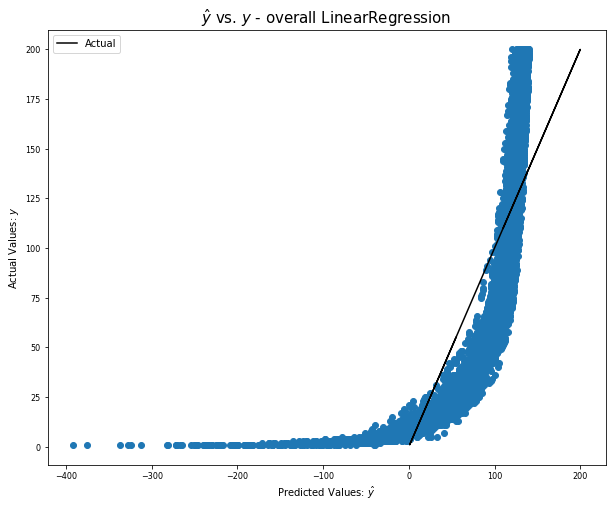

In [216]:
# Plotting to compare actual vs preds for avg rank 
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test,y_test);
plt.plot( y_test,y_test, c = 'black');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - overall LinearRegression", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);
plt.savefig('../LinearRegression.png', dpi = 100)

### Model: Linear Regression (+ Scaling/PCA)

In [217]:
# creating new columns/dataframe to be used as matrix for our models
new_cols_rank = df_Global.groupby(['Date','Artist', 'Region']).agg({'Position': ['mean', 'min', 'max']})
new_cols_rank.columns = ['Average Rank', 'Hignest Rank', 'Lowest Rank']

In [218]:
new_cols_rank

Average Rank  Hignest Rank  Lowest Rank
Date       Artist       Region                                         
2017-01-01 21 Savage    Global     85.000000            72           98
           AJR          Global    143.000000           143          143
           Adele        Global    100.333333            73          132
           Alan Walker  Global     56.000000            45           67
           Alessia Cara Global     48.500000            36           61
...                                      ...           ...          ...
2018-01-09 Yandel       Global    166.000000           166          166
           ZAYN         Global     79.500000            24          135
           Zac Efron    Global     59.000000            59           59
           Zedd         Global    150.000000           150          150
           Ziv Zaifman  Global     91.000000            91           91

[46720 rows x 3 columns]

In [219]:
# creating new columns/dataframe to be used as matrix for our models for ranks 
new_cols_streams = df_Global.groupby(['Date', 'Artist','Region']).agg({'Streams': ['mean', 'max', 'min']})
new_cols_streams.columns = ['Average Streams', 'Maximum Streams', 'Minimum Streams']

In [220]:
new_cols_streams

Average Streams  Maximum Streams  \
Date       Artist       Region                                     
2017-01-01 21 Savage    Global         613512.0           673320   
           AJR          Global         428247.0           428247   
           Adele        Global         562204.0           672465   
           Alan Walker  Global         824931.0           936813   
           Alessia Cara Global         905185.5          1031598   
...                                         ...              ...   
2018-01-09 Yandel       Global         590444.0           590444   
           ZAYN         Global        1258263.0          1852731   
           Zac Efron    Global        1119290.0          1119290   
           Zedd         Global         629515.0           629515   
           Ziv Zaifman  Global         865881.0           865881   

                                Minimum Streams  
Date       Artist       Region                   
2017-01-01 21 Savage    Global           553704  
           AJR          Global           428247  
           Adele        Global           448638  
           Alan Walker  Global           713049  
           Alessia Cara Global           778773  
...                                         ...  
2018-01-09 Yandel       Global           590444  
           ZAYN         Global           663795  
           Zac Efron    Global          1119290  
           Zedd         Global           629515  
           Ziv Zaifman  Global           865881  

[46720 rows x 3 columns]

In [221]:
# merging two DF for consolidated data
df_Global_new = pd.merge(new_cols_rank, new_cols_streams, on =['Date', 'Region', 'Artist'])
df_Global_new.reset_index(level=['Region','Artist'], inplace = True)
df_Global_new

,Region,Artist,Average Rank,Hignest Rank,Lowest Rank,Average Streams,Maximum Streams,Minimum Streams
Date,,,,,,,,
2017-01-01,Global,21 Savage,85.000000,72,98,613512.0,673320,553704
2017-01-01,Global,AJR,143.000000,143,143,428247.0,428247,428247
2017-01-01,Global,Adele,100.333333,73,132,562204.0,672465,448638
2017-01-01,Global,Alan Walker,56.000000,45,67,824931.0,936813,713049
2017-01-01,Global,Alessia Cara,48.500000,36,61,905185.5,1031598,778773
...,...,...,...,...,...,...,...,...
2018-01-09,Global,Yandel,166.000000,166,166,590444.0,590444,590444
2018-01-09,Global,ZAYN,79.500000,24,135,1258263.0,1852731,663795
2018-01-09,Global,Zac Efron,59.000000,59,59,1119290.0,1119290,1119290


In [222]:
df_Global_new_dummies = pd.get_dummies(data=df_Global_new, columns=['Artist'])
df_Global_new_dummies

,Region,Average Rank,Hignest Rank,Lowest Rank,Average Streams,Maximum Streams,Minimum Streams,Artist_*NSYNC,Artist_187 Strassenbande,Artist_2 Chainz,...,Artist_ZAYN,Artist_Zac Efron,Artist_Zara Larsson,Artist_Zay Hilfigerrr,Artist_Zedd,Artist_Zion & Lennox,Artist_Ziv Zaifman,Artist_alt-J,Artist_blackbear,Artist_gnash
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,Global,85.000000,72,98,613512.0,673320,553704,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01,Global,143.000000,143,143,428247.0,428247,428247,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01,Global,100.333333,73,132,562204.0,672465,448638,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01,Global,56.000000,45,67,824931.0,936813,713049,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01,Global,48.500000,36,61,905185.5,1031598,778773,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-09,Global,166.000000,166,166,590444.0,590444,590444,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-09,Global,79.500000,24,135,1258263.0,1852731,663795,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2018-01-09,Global,59.000000,59,59,1119290.0,1119290,1119290,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [223]:
# Choosing target
y_new = df_Global_new_dummies[['Lowest Rank', 'Hignest Rank', 'Average Rank']]

In [224]:
X_new = df_Global_new_dummies.drop(
    columns = ['Region', 'Lowest Rank', 'Hignest Rank', 'Average Rank'])

In [225]:
# split data into test/train sets 
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new,
                                                   random_state = 42)

In [226]:
# Tunning model & fit it 
lm = MultiOutputRegressor(LinearRegression())
lm.fit(X_train, y_train)
print(f'Training Score: {round(lm.score(X_train, y_train),4)}.')
print(f'Testing Score: {round(lm.score(X_test, y_test),4)}.')

Training Score: 0.7456.
Testing Score: -6268945.0059.


In [227]:
# Scaling data for PCA 
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [228]:
# Instantiate PCA and fitting
pca = PCA()
pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

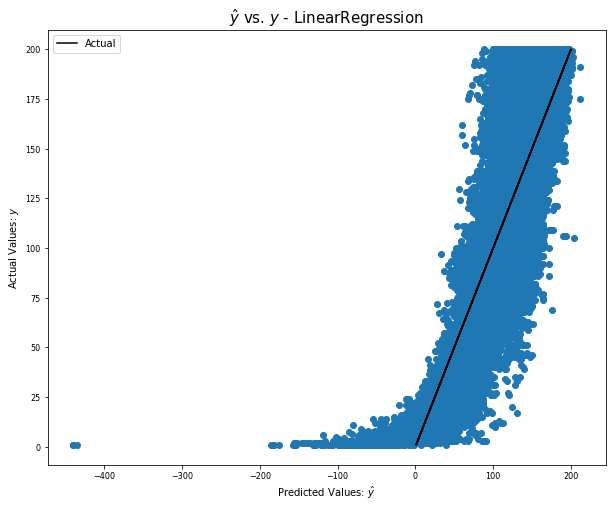

In [234]:
# Selecting components 
var_exp = pca.explained_variance_ratio_
# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)

#instantiate with important components 
# 用sklearn封装的PCA方法，做PCA的代码如下。
# PCA方法参数n_components，如果设置为整数，则n_components=k。
# 如果将其设置为小数，则说明降维后的数据能保留的信息。
# https://blog.csdn.net/ybdesire/article/details/64546435
pca = PCA(n_components =0.99)
pca.fit(X_train)

# Tune & fit model 
lm = MultiOutputRegressor(LinearRegression())
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
lm.fit(Z_train, y_train)

# print(f'Training R2 Score: {round(lm.score(Z_train, y_train),4)}')
# Training R2 Score: 0.7166
# print(f'Testing R2 Score: {round(lm.score(Z_test, y_test),4)}')
# Testing R2 Score: 0.707

#Look into predictions 
y_pred_train= lm.predict(Z_train)
y_pred_test = lm.predict(Z_test)

# Plotting to compare actual vs preds for avg rank 
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test,y_test);
plt.plot( y_test,y_test, c = 'black');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - LinearRegression", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);
plt.savefig('../MultipleLinearRegression.png', dpi = 100)

In [235]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('MAE:', metrics.mean_absolute_error(y_test,y_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))

RMSE: 30.172257028137896
MAE: 23.498095955611436
MSE: 910.3650941720167


### Model : RandomForest Regressor (+Scaling/PCA)

In [236]:
#Tuning model & Fit it 
rf = MultiOutputRegressor(RandomForestRegressor())
rf.fit(X_train, y_train)
print(f'Training Score: {round(rf.score(X_train, y_train),4)}.')
print(f'Testing Score: {round(rf.score(X_test, y_test),4)}.')

Training Score: 0.9927.
Testing Score: 0.9463.


In [237]:
# +scaling & PCA 
rf = MultiOutputRegressor(RandomForestRegressor())
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
rf.fit(Z_train, y_train)
print(f'Training Score: {round(rf.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(rf.score(Z_test, y_test),4)}')

Training Score: 0.9932
Testing Score: 0.9479


In [238]:
# Look into predictions 
y_pred_train_rf= rf.predict(Z_train)
y_pred_test_rf = rf.predict(Z_test)

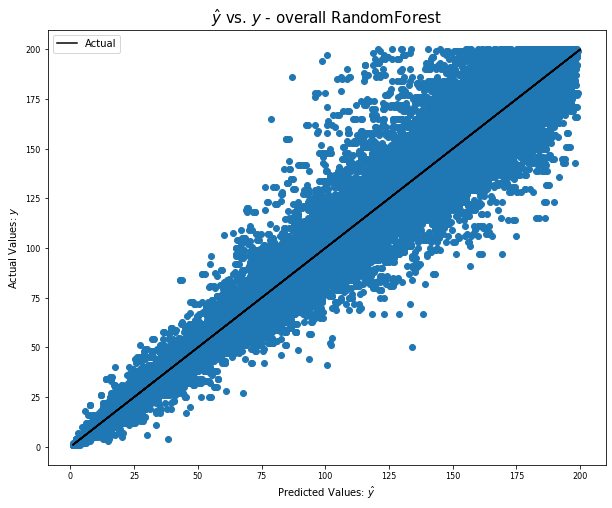

In [242]:
# Plotting to compare actual vs preds for average rank 
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test_rf,y_test);
plt.plot( y_test,y_test, c = 'black');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - overall RandomForest", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);
plt.savefig('../residual_overall_random_forest.png', dpi = 100)

In [243]:
preds_rf = pd.DataFrame(y_pred_test_rf)
preds_rf.columns=['Average Rank Prediction', 'Hignest Rank Prediction', 'Lowest Rank Prediction']
preds_rf.apply(np.int64)

,Average Rank Prediction,Hignest Rank Prediction,Lowest Rank Prediction
0,25,25,25
1,168,171,171
2,120,119,119
3,177,113,140
4,103,97,98
...,...,...,...
11675,171,58,113
11676,115,117,115
11677,85,86,86
11678,72,40,57


In [244]:
# selecting relevant column for seperate assessment
y_test_avg = y_test['Average Rank']
y_test_hi = y_test['Hignest Rank']
y_test_low = y_test['Lowest Rank']

# creating Dataframe for predictions
y_pred_test_avg = preds_rf['Average Rank Prediction']
y_pred_test_hi = preds_rf['Hignest Rank Prediction']
y_pred_test_low = preds_rf['Lowest Rank Prediction']

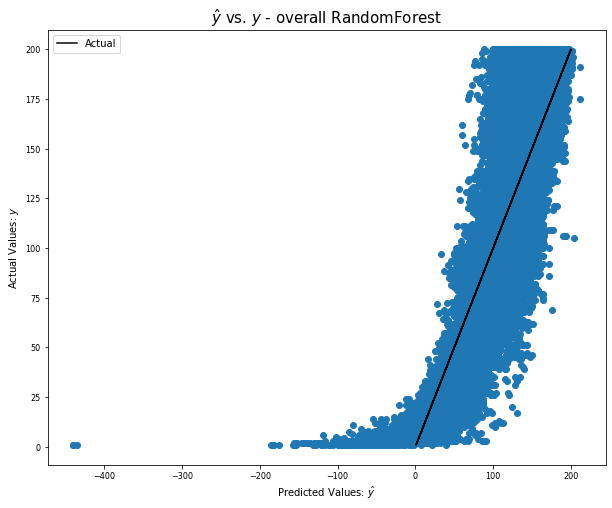

In [246]:
# Plotting to compare actual vs preds for avg rank 
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test,y_test);
plt.plot( y_test,y_test, c = 'black');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - overall RandomForest", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);
plt.savefig('../residual_overall_lr.png', dpi = 100)

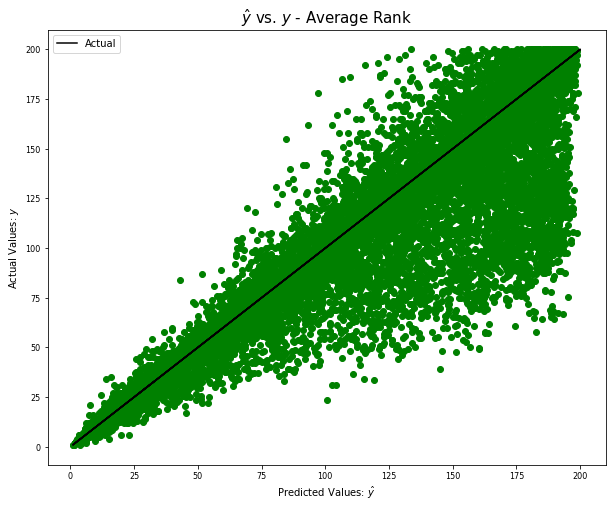

In [248]:
# Plotting to compare actual vs preds for avg rank 
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test_avg,y_test_avg, c = 'green');
plt.plot( y_test,y_test, c = 'black');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - Average Rank", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);
plt.savefig('../residual_average_rank_rf.png', dpi = 100)

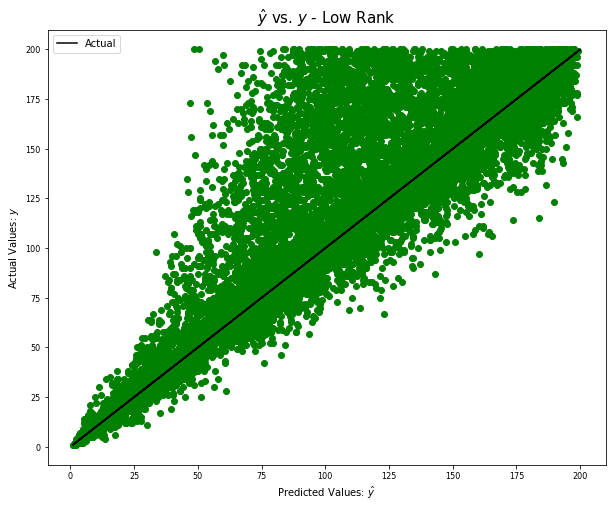

In [250]:
# Plotting to compare actual vs preds for low rank 
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test_low,y_test_low, c = 'green');
plt.plot( y_test,y_test, c = 'black');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - Low Rank", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);
plt.savefig('../residual_low_rank_rf.png', dpi = 100)

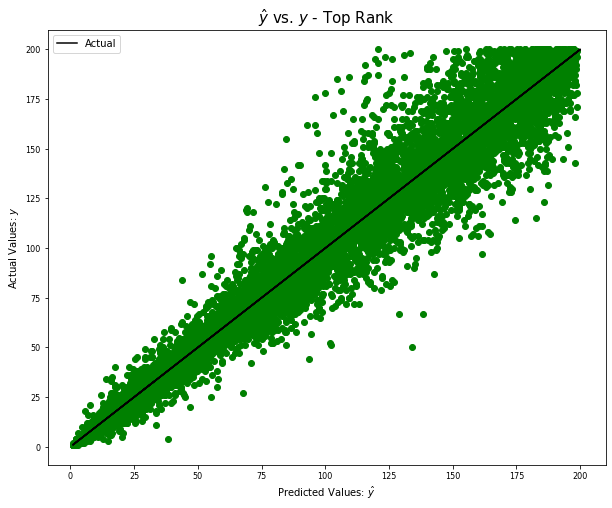

In [252]:
# Plotting to compare actual vs preds for top rank 
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test_hi,y_test_hi, c = 'green');
plt.plot( y_test,y_test, c = 'black');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - Top Rank", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);
plt.savefig('../residual_top_rank_rf.png', dpi = 100)

Text(0.5, 0.98, 'Rank Prediction by using Random Forest')

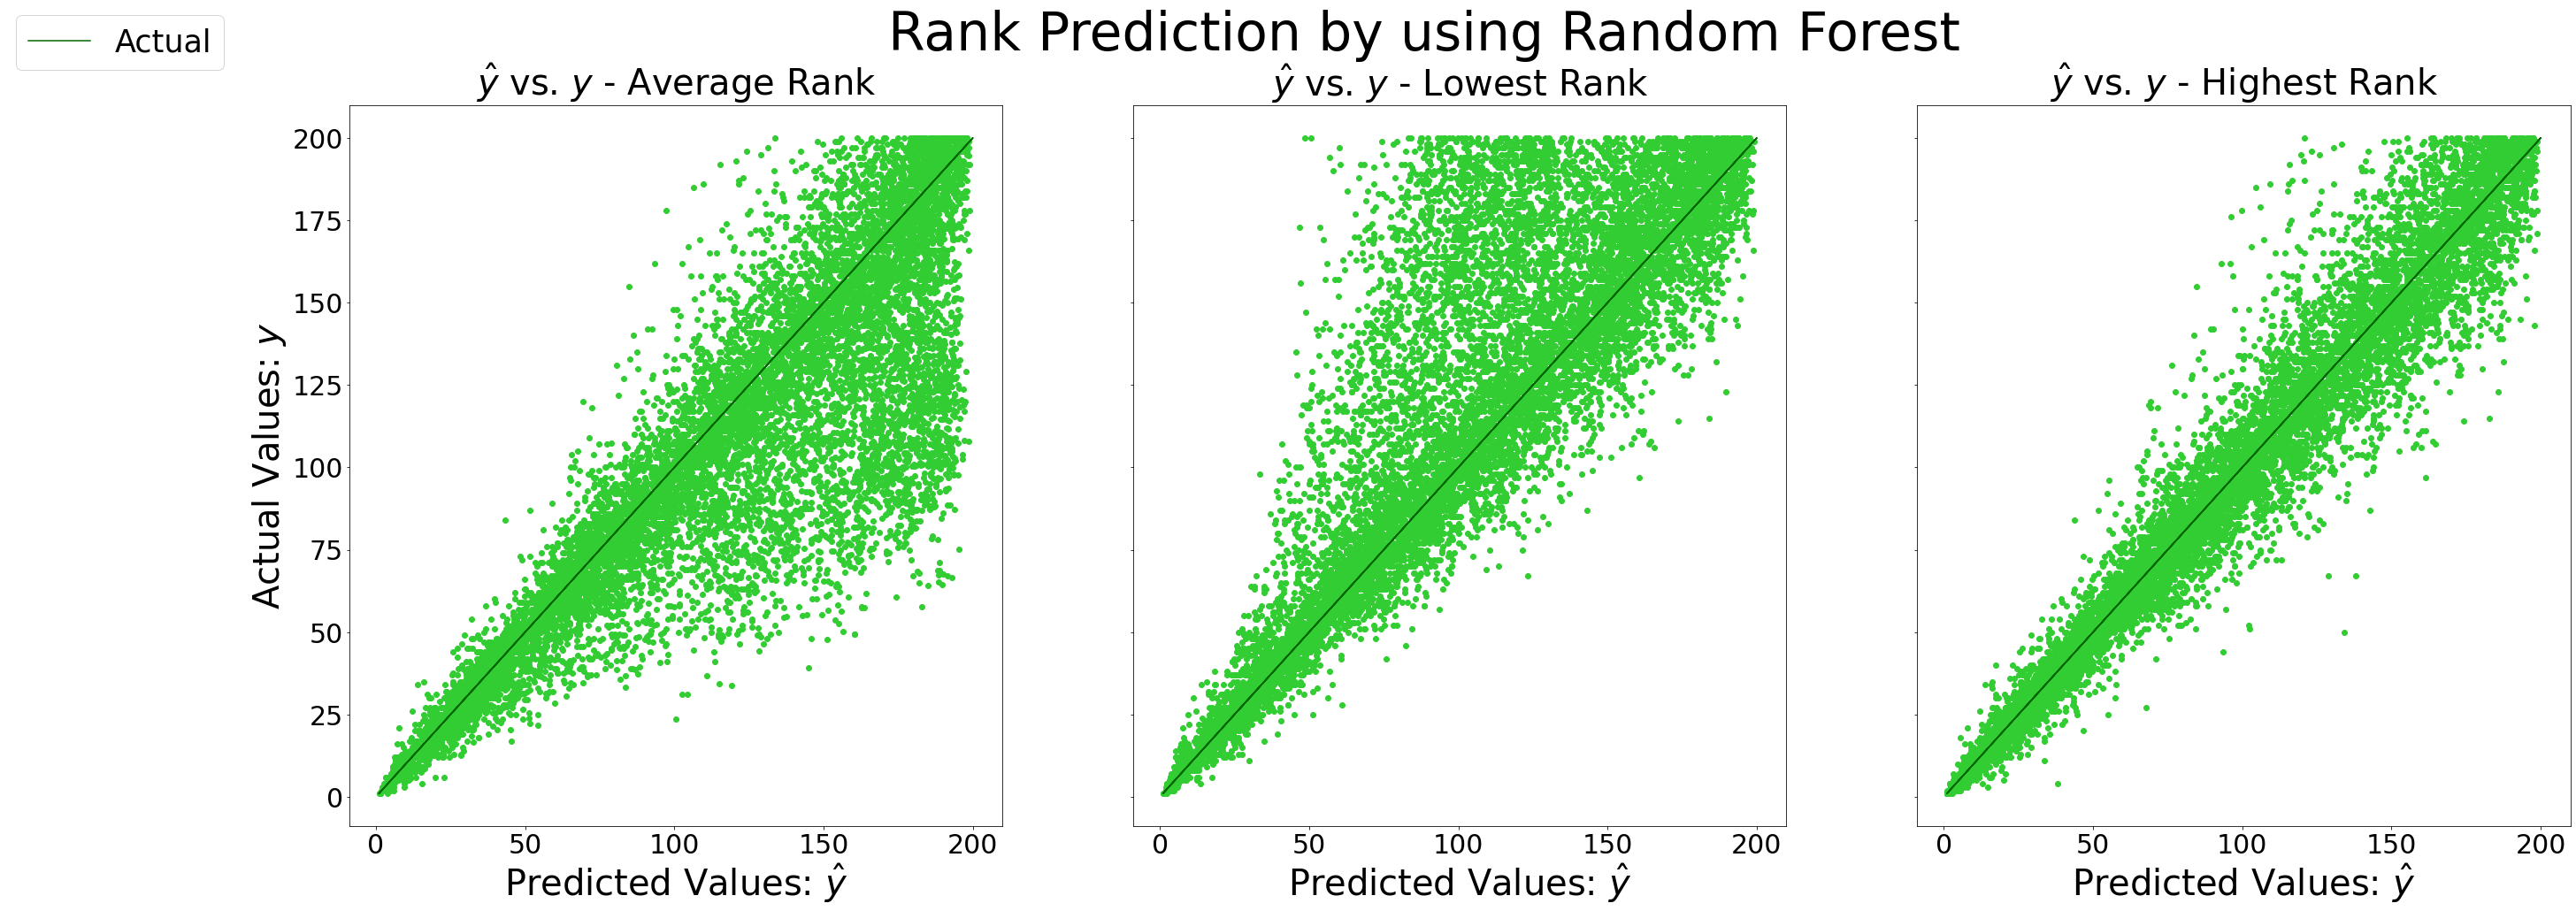

In [328]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(45, 15), sharey=True)

### Plotting to compare actual vs preds for avg rank 
ax1.scatter(y_pred_test_avg,y_test_avg, c = 'limegreen')
ax1.plot( y_test,y_test, c = 'darkgreen')
ax1.set_title("$\hat{y}$ vs. $y$ - Average Rank", fontsize = 40)
ax1.set_xlabel("Predicted Values: $\hat{y}$", fontsize=40)
ax1.set_ylabel("Actual Values: $y$", fontsize=40)
ax1.yaxis.set_tick_params(labelsize=30)
ax1.xaxis.set_tick_params(labelsize=30)

### Plotting to compare actual vs preds for low rank 
ax2.scatter(y_pred_test_low,y_test_low, c = 'limegreen')
ax2.plot( y_test,y_test, c = 'darkgreen')
ax2.set_title("$\hat{y}$ vs. $y$ - Lowest Rank", fontsize = 40)
ax2.set_xlabel("Predicted Values: $\hat{y}$", fontsize=40)
ax2.yaxis.set_tick_params(labelsize=30)
ax2.xaxis.set_tick_params(labelsize=30)

### Plotting to compare actual vs preds for highest rank 
ax3.scatter(y_pred_test_hi,y_test_hi, c = 'limegreen')
ax3.plot( y_test,y_test, c = 'darkgreen')
ax3.set_title("$\hat{y}$ vs. $y$ - Highest Rank", fontsize = 40)
ax3.set_xlabel("Predicted Values: $\hat{y}$", fontsize=40)
ax3.yaxis.set_tick_params(labelsize=30)
ax3.xaxis.set_tick_params(labelsize=30)

fig.legend(['Actual'],loc='upper left', fontsize=35);
fig.savefig('../residual_rank_rf.png', dpi = 100)
fig.suptitle('Rank Prediction by using Random Forest', fontsize=60)

In [253]:
print('RMSE Train - Overall:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_rf)))
print('RMSE Test - Overall:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_rf)))
print('RMSE Test - Average Rank:', np.sqrt(metrics.mean_squared_error(y_test_avg, y_pred_test_avg)))
print('RMSE Test - Top Rank:',np.sqrt(metrics.mean_squared_error(y_test_hi, y_pred_test_hi)))
print('RMSE Test -Low Rank:',np.sqrt(metrics.mean_squared_error(y_test_low, y_pred_test_low)))

RMSE Train - Overall: 4.570414183415023
RMSE Test - Overall: 12.655175947918814
RMSE Test - Average Rank: 29.723028233061715
RMSE Test - Top Rank: 12.11844785016132
RMSE Test -Low Rank: 30.63653419677821


#### Mean Absolute Error

In [254]:
# TRAIN - Mean Absolute Error represents median distance from the predicted value.
metrics.mean_absolute_error(y_train,y_pred_train_rf)

3.031785913601101

In [255]:
#TEST - Mean Absolute Error represents median distance from the predicted value.
metrics.mean_absolute_error(y_test,y_pred_test_rf)

8.368568036559806

#### Mean Squarred Error

In [256]:
# TRAIN - Mean Squarred Error represents avg distance squared from the predicted value.
metrics.mean_squared_error(y_train, y_pred_train_rf)

20.88868580796121

In [257]:
#TEST - Mean Squarred Error represents avg distance squared from the predicted value.
metrics.mean_squared_error(y_test, y_pred_test_rf)

160.15347827278285

## Clustering
Here is some unsupervised learning analysis. Each song in the data set will be a feature. The value will be the percentage of plays for each song by country

In [294]:
# create the features by first calculating percentage of plays in a country for each song
cluster = df.copy()
cluster['Artist_Trackname'] = cluster['Artist'] + ' ' + cluster['Track Name']

# get the total plays for each track by country
cluster['Total_Song_Plays'] = cluster.groupby(['Region', 'Artist_Trackname'])['Streams'].transform('sum')

# get the total plays in total for each country
cluster['Total_Plays'] = cluster.groupby(['Region'])['Streams'].transform('sum')

cluster

# drop duplicate rows
cluster = cluster[['Artist_Trackname', 'Total_Song_Plays', 'Total_Plays', 'Region', 'Continent','Region Code']].drop_duplicates()

# calculate the percentage of plays that were for each song
cluster['Percent_Plays'] = cluster['Total_Song_Plays'] / cluster['Total_Plays']

cluster


,Artist_Trackname,Total_Song_Plays,Total_Plays,Region,Continent,Region Code,Percent_Plays
0,CNCO Reggaetón Lento (Bailemos),3173419,318288247,Ecuador,South America,EC,0.009970
1,Shakira Chantaje,2645162,318288247,Ecuador,South America,EC,0.008311
2,Zion & Lennox Otra Vez (feat. J Balvin),3806808,318288247,Ecuador,South America,EC,0.011960
3,Ricky Martin Vente Pa' Ca,2139631,318288247,Ecuador,South America,EC,0.006722
4,J Balvin Safari,2322594,318288247,Ecuador,South America,EC,0.007297
...,...,...,...,...,...,...,...
3440307,Nicholas Tse 有火,5776,295717291,Hong Kong,Asia,HK,0.000020
3440393,帶菌者 繼續追,2178,295717291,Hong Kong,Asia,HK,0.000007
3440593,Bad Bunny Sensualidad,6884,295717291,Hong Kong,Asia,HK,0.000023
3440974,Miguel Sky Walker,4985,295717291,Hong Kong,Asia,HK,0.000017


In [295]:
# pivot the table to get the features
cluster = cluster.pivot(index='Region Code', columns='Artist_Trackname', values='Percent_Plays')

# pivot table creates NaN values when there is no value. In reality, these values should be zero.
cluster = cluster.fillna(0)

cluster

Artist_Trackname,#TocoParaVos Bailemos juntos,#TocoParaVos Enganchado #TocoParaVos - Cumbia Mix,#TocoParaVos Hasta la luna,#TocoParaVos Me provoca (Noche loca),#TocoParaVos Su fiel admirador,#TocoParaVos Sólo necesito,#TocoParaVos Tan infinito,#TocoParaVos Tengo un vicio,#TocoParaVos Tu beso y tu piel (feat. Gustas Mio),#TocoParaVos Uh amor (feat. Lionel Ferro),...,黃義達 到底多久,黃義達 匿名的寶貝,黃義達 每天的每夜,黃聖萊Lex 看好,黃荻鈞 半年,黄靖伦 我會一直記得,黄靖伦 舊傷,鼓鼓 為愛而愛,齊晨 到此為止,龔詩嘉 My Island Home
Region Code,,,,,,,,,,,,,,,,,,,,,
AR,0.000000,0.000014,0.000772,0.000000,0.000000,0.000005,0.000000,0.000000,0.000005,0.000005,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [231]:
# # pivot the table to get the features
# cluster = cluster.pivot(index='Region', columns='Artist_Trackname', values='Percent_Plays')

# # pivot table creates NaN values when there is no value. In reality, these values should be zero.
# cluster = cluster.fillna(0)

# cluster

In [296]:
# Calculate 2 PCA components for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(cluster)
Region_code = cluster.index
pca_results = pd.DataFrame(pca_features, columns=['f1', 'f2'])
pca_results['Region Code'] = Region_code
pca_results['Continent'] = pca_results['Region Code'].apply(getContinentName)
pca_results['Region Name'] = pca_results['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
pca_results['Continent'] = pca_results['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
pca_results['Region'] = pca_results['Region Name'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

pca_results =  pca_results.loc[(pca_results['Continent'] != 'Global')]
pca_results

,f1,f2,Region Code,Continent,Region Name,Region
0,0.053687,0.002267,AR,South America,Argentina,Argentina
1,-0.019797,-0.006728,AT,Europe,Austria,Austria
2,-0.024785,-0.011558,AU,Oceania,Australia,Australia
3,-0.021072,-0.003217,BE,Europe,Belgium,Belgium
4,0.059860,0.012930,BO,South America,"Bolivia, Plurinational State of",Bolivia
5,-0.002579,-0.022316,BR,South America,Brazil,Brazil
6,-0.021079,-0.010443,CA,North America,Canada,Canada
7,-0.016166,0.000599,CH,Europe,Switzerland,Switzerland
8,0.055789,-0.000266,CL,South America,Chile,Chile
9,0.047901,0.005299,CO,South America,Colombia,Colombia


Text(0.5, 1.0, 'PCA two-dimensional features')

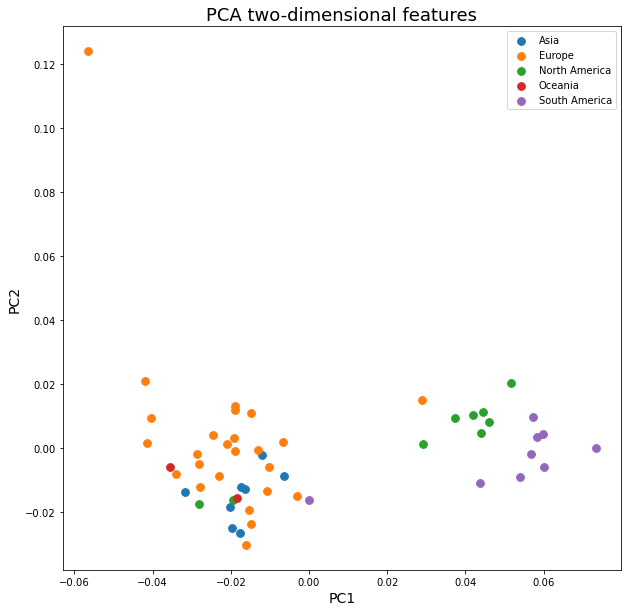

In [367]:
# visualize the 2 PCA components
mpl.rcParams['figure.figsize'] = (10, 10)

pca_results['PC1'] = pca_results.f1 + np.random.normal(0, 0.008, len(pca_results.f1))
pca_results['PC2'] = pca_results.f2 + np.random.normal(0, 0.008, len(pca_results.f2))
# ax = pca_results.plot('f1', 'f2', kind='scatter')
# pca_results[['f1','f2','Continent']].apply(lambda x: ax.text(*x, rotation=30),axis=1)
# plt.title('PCA two-dimensional features')

label = pca_results['Continent']
uniq = np.unique(label)
for i in uniq:
   plt.scatter(pca_results['PC1'][label == i], pca_results['PC2'][label == i], s=60, label = i)
plt.ylabel('PC2', size=14)
plt.xlabel('PC1', size=14)
plt.legend()
plt.title('PCA two-dimensional features', size=18)

This chart runs PCA on the features to be able to visualize the features in two dimensions. It divide the data into about two clusters. It's clear that Latin American Spanish speaking regions have similar characteristics and are clustered together. Arguably there is also an European cluster of some sort.

### For each cluster

In [320]:
pca_results

,f1,f2,Region Code,Continent,Region Name,Region,PC1,PC2
0,0.053687,0.002267,AR,South America,Argentina,Argentina,0.059517,-0.002855
1,-0.019797,-0.006728,AT,Europe,Austria,Austria,-0.020895,-0.014644
2,-0.024785,-0.011558,AU,Oceania,Australia,Australia,-0.025402,-0.008995
3,-0.021072,-0.003217,BE,Europe,Belgium,Belgium,-0.031616,-0.007566
4,0.059860,0.012930,BO,South America,"Bolivia, Plurinational State of",Bolivia,0.055868,0.013939
5,-0.002579,-0.022316,BR,South America,Brazil,Brazil,0.004904,-0.036491
6,-0.021079,-0.010443,CA,North America,Canada,Canada,-0.026154,-0.015734
7,-0.016166,0.000599,CH,Europe,Switzerland,Switzerland,-0.017539,0.016216
8,0.055789,-0.000266,CL,South America,Chile,Chile,0.067207,0.001871
9,0.047901,0.005299,CO,South America,Colombia,Colombia,0.043990,0.004591


In [319]:
# Select ranges for the three major clusters
groupA = pca_results[pca_results['PC1'] > 0.02] # America
groupB = pca_results[(pca_results['PC2'] <= 0.04) & (pca_results['PC1'] < 0.02)]

For Group A (America):

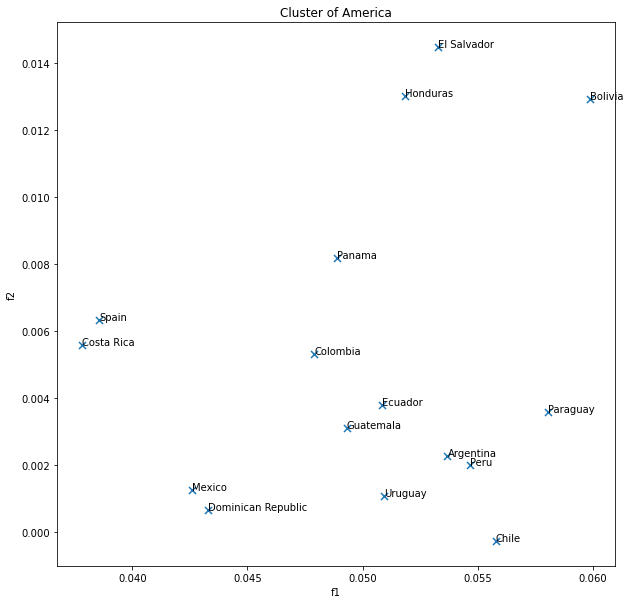

In [340]:
# plot the Spanish Speakers cluster
# ax = groupA.plot('PC1', 'PC2', kind='scatter')
# groupA[['PC1','PC2','Region']].apply(lambda x: ax.text(*x),axis=1);
# plt.title('Cluster of America')

ax = groupA.plot('f1', 'f2', kind='scatter', s=50, marker='x')
groupA[['f1','f2','Region']].apply(lambda x: ax.text(*x),axis=1);
plt.title('Cluster of America')
plt.savefig('GroupA.png')

For Group B (Eurasia):

Text(0.5, 1.0, 'Cluster of Eurasia')

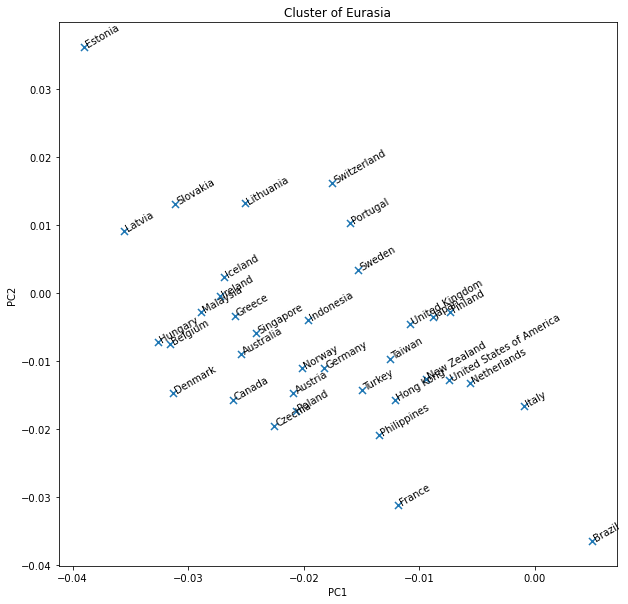

In [339]:
# ax = groupB.plot('f1', 'f2', kind='scatter', s=50, marker='x')
# groupB[['f1','f2','Region']].apply(lambda x: ax.text(*x),axis=1);
# plt.title('Cluster of Eurasia')
ax = groupB.plot('PC1', 'PC2', kind='scatter', s=50, marker='x')
groupB[['PC1','PC2','Region']].apply(lambda x: ax.text(*x, rotation=30, fontsize=10),axis=1);
plt.title('Cluster of Eurasia')